## INTEL IMAGE CLASSIFICATION PROJESİ


In [18]:
#kütüphaneleri yükleme
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

#gpu kontrol
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")


TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


## Kütüphanelerin yüklenmesi ve GPU kontrolü  
- **os,numpy,matplotlib,seaborn**:Veri işleme ve görselleştirme için.  
- **tensorflow,keras**: Derin öğrenme modellerini kurmak ve eğitmek için.  
- **ImageDataGenerator**:Görüntü ön işleme ve data augmentationişlemleri için.  
- **scikit-learn(train_test_split,classification_report,confusion_matrix)**:Eğitim/veri ayrımı ve model performans değerlendirmesi için.  
- **time,warnings**:Çalışma sürelerini ölçmek ve gereksiz uyarıları gizlemek için.
Ayrıca, Tensorflow sürümü ve GPU'nun kullanılabilirliği kontrol edilmiştir.
Bu sayede modelin GPU üzerinde daha hızlı eğitilip eğitilemeyeceği anlaşılır.  

## 1.Veri Setini Yükleme ve Keşfetme

Sınıf isimleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Toplam veri: (14034, 150, 150, 3) (14034,)
Eğitim verisi: (11227, 150, 150, 3) (11227,)
Test verisi: (2807, 150, 150, 3) (2807,)
Sınıf sayısı: 6


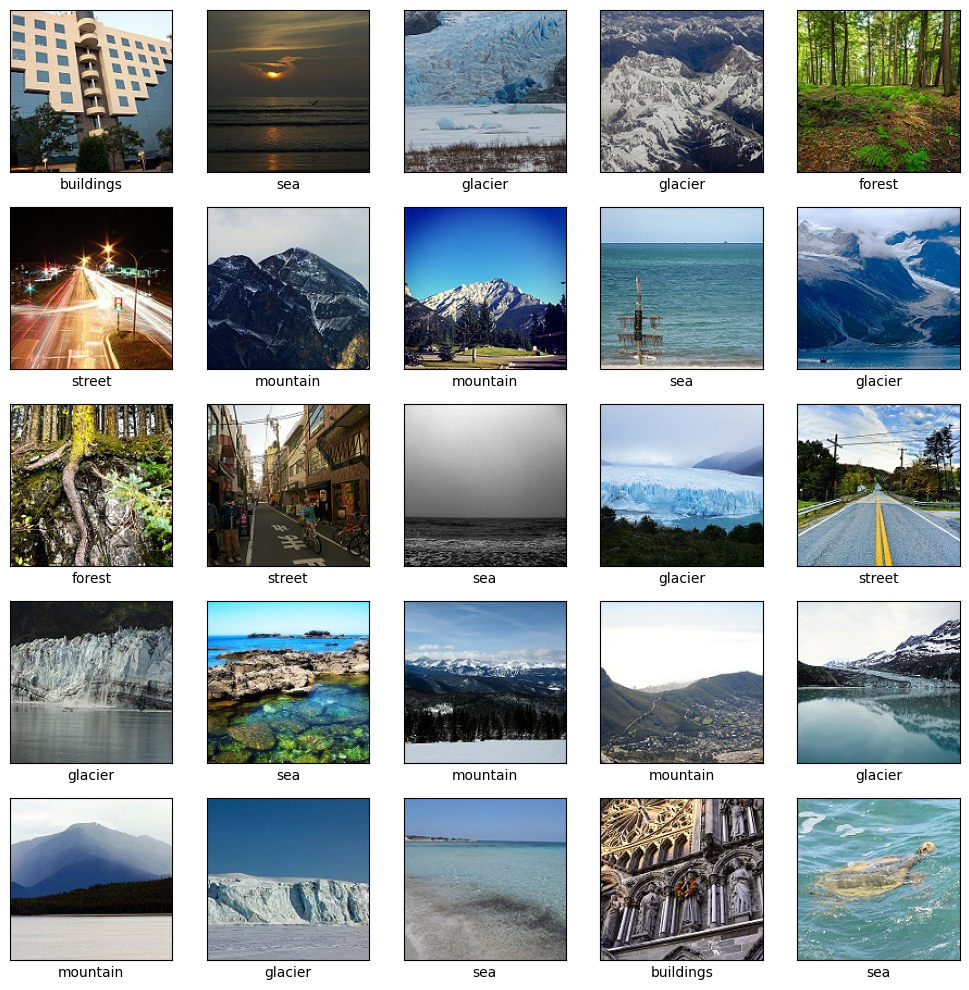

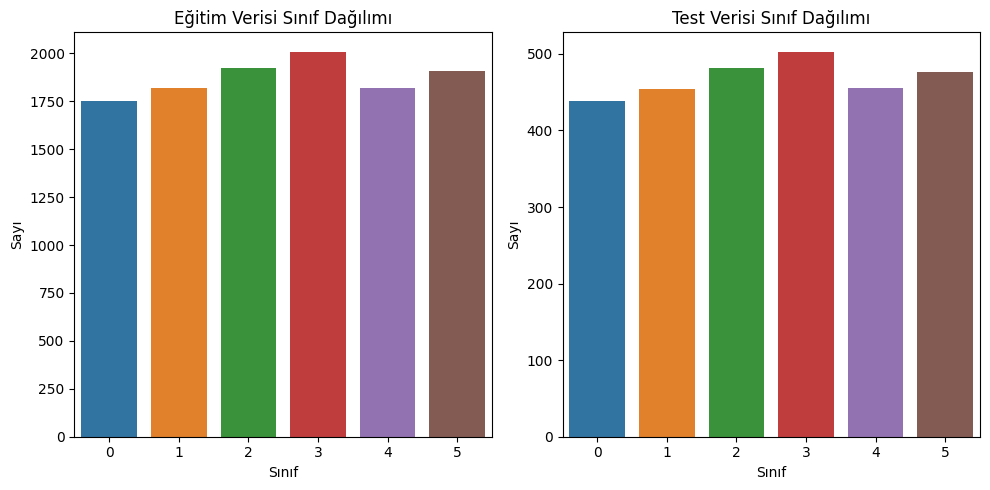

In [19]:
data_dir = "../input/intel-image-classification/seg_train/seg_train"

#parametreler
img_height, img_width = 150,150

#sınıflar
class_names =sorted(os.listdir(data_dir))
print("Sınıf isimleri:", class_names)

#Veri ve etiket listesi
X=[]
y=[]

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        img_path = os.path.join(class_dir, fname)
        img= load_img(img_path, target_size=(img_height, img_width))
        img_array =img_to_array(img)
        X.append(img_array)
        y.append(label)

X= np.array(X,dtype="float32")
y= np.array(y,dtype="int32")

print("Toplam veri:", X.shape, y.shape)

#normalizasyon
X= X / 255.0

#eğitim-test ayırma
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Eğitim verisi:", X_train.shape, y_train.shape)
print("Test verisi:", X_test.shape, y_test.shape)
print("Sınıf sayısı:", len(np.unique(y_train)))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[y_train[i]])

plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=y_train.flatten())
plt.title('Eğitim Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Sayı')

plt.subplot(1,2,2)
sns.countplot(x=y_test.flatten())
plt.title('Test Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Sayı')
plt.tight_layout()
plt.show()




## Veri Setinin Yüklenmesi ve Hazırlanması 

- **Veri yolu**:`../input/intel-image-classification/seg_train/seg_train` klasöründen alınmıştır.  
- **Resim boyutları**:Tüm görseller 150*150 piksele yeniden boyutlandırılmıştır.  
- **Sınıflar**:Veri setindeki alt klasörler okunarak sınıf isimleri otomatik çıkarılmıştır.  
- **X(görseller)** ve **y(etiketler)** listeleri oluşturulmuş, numpy dizilerine dönüştürülmüştür.  
- **Normalizasyon**:Piksel değerleri 0-255 aralığının 0-1 aralığına ölçeklendirilmiştir.  
- **Eğitim-Test ayrımı**:Verinin %80'i eğitim, %20'si test için ayrılmıştır.Ayrıca **strafiy=y** parametresi ile sınıflar dengeli olacak şekilde bölünmüştür.  

## Veri Görselleştirme  

- Eğitim verisinden 25 örnek görsel rastgele seçilip görselleştirilmiştir.  
- Eğitim ve test verisindeki **sınıf dağılımları** çubuk grafikler ile gösterilmiştir.  

Bu adım, verinin doğru yüklendiğini ve sınıf dağılımlarının dengeli olup olmadığını kontrol etmeye yardımcı olur.


## 2.Veri Ön İşleme

In [20]:
#sınıf sayısını al
num_classes= len(class_names)


#etiketleri one-hot encoding formatına dönüştür
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

#veri artırma için ImageDatGenerator kullan
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

#veri artırma işlemini eğitim verisine uygula
datagen.fit(X_train)

#normalizasyon ve one-hot encoding sonrası veri boyutlarını kontrol et
print("Normalize edilmiş eğitim verisi şekli:", X_train.shape)
print("One-hot encoded eğitim etiketleri şekli:", y_train_categorical.shape)




Normalize edilmiş eğitim verisi şekli: (11227, 150, 150, 3)
One-hot encoded eğitim etiketleri şekli: (11227, 6)


## Etiketlerin Hazırlanması ve Veri Artırma  
- **Sınıf Sayısı**:Veri setindeki toplam sınıf sayısı `num_classes` değişkenine atandı.  
- **One-Hot Encoding**:Eğitim (`y_train`) ve test (`y_test`) etiketleri, modelin çok sınıflı sınıflandırma yapabilmesi için **one-hot encoding** formatına dönüştürüldü.  
  - Örn:"Orman" sınıfı `[0, 1, 0, 0, 0, 0]` şeklinde gösterilir.  

## Veri Artırma  
- **Amaç**:Eğitim verisinin çeşitliliğini artırarak modelin aşırı öğrenmesini (overfitting) engellemek.  
- **ImageDataGenerator Parametreleri**:   
  - `rotation_range=15` -> Görselleri ±15° döndürme  
  - `width_shift_range=0.1` -> Yatay kaydırma  
  - `height_shift_range=0.1` -> Dikey kaydırma  
  - `horizontal_flip=True` -> Görselleri yatay çevirme  
  - `zoom_range=0.1` -> Yakınlaştırma  

- Veri artırma sadece **eğitim verisine** uygulanmıştır.  

Son olarak, normalizasyon ve one-hot encoding sonrası verilerin şekilleri ekrana yazdırılarak kontrol edilmiştir.

## 3.Temel CNN Modeli Oluşturma

In [21]:
#temel CNN modeli
def create_cnn_model(input_shape=(150,150,3),num_classes=6):
    model=keras.Sequential([
        #ilk evrişim bloğu
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),

        #ikinci evrişim bloğu
        layers.Conv2D(64,(3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64,(3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        #üçüncü evrişim bloğu
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        #sınıflandırıcı
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#model oluşturma
cnn_model = create_cnn_model(input_shape=(150,150,3), num_classes=num_classes)

#model özetini görüntüleyelim
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,597,734 (21.35 MB)

 Trainable params: 5,597,030 (21.35 MB)

 Non-trainable params: 704 (2.75 KB)

## Temel CNN Modeli

Bu bölümde, görüntü sınıflandırma için **sıfırdan bir CNN modeli** tasarlanmıştır. Model, üç adet **evrişim bloğu (convolutional block)** ve sonrasında tam bağlı katmanlardan oluşmaktadır.

### Model Yapısı  
1. **Birinci Evrişim Bloğu**  
  - Conv2D (32 filtre)
  - Batch Normalization
  - Conv2D (32 filtre)
  - MaxPooling2D
  - Dropout (0.2)  

2. **İkinci Evrişim Bloğu**  
  - Conv2D (64 filtre)
  - Batch Normalization
  - Conv2D (64 filtre)
  - MaxPooling2D
  - Dropout (0.3)  

3. **Üçüncü Evrişim Bloğu**  
  - Conv2D (128 filtre)
  - Batch Normalization
  - Conv2D(128 filtre)
  - MaxPooling2D
  - Dropout (0.4)  

4. **Sınıflandırıcı Katmanlar**  
  - Flatten
  - Dense
  - Batch Normalization
  - Dropout (0.5)
  - Dense (Çıkış: `num_classes`, Softmax aktivasyonu)  
  

### Önemli Noktalar
- **Batch Normalization**: Öğrenmeyi hızlandırır ve kararlılığı artırır.  
- **Dropout**: Aşırı öğrenmeyi (overfitting) azaltır.  
- **Softmax Çıkışı**: Çok sınıflı sınıflandırma için olasılık dağılımı üretir.  

Modelin özet çıktısı (`summary`) ile katmanların boyutları ve parametre sayıları incelenmiştir.


## 4.Modeli Derleme ve Eğitme

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 309ms/step - accuracy: 0.5001 - loss: 1.3814 - val_accuracy: 0.1621 - val_loss: 3.6918 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 278ms/step - accuracy: 0.7194 - loss: 0.7779 - val_accuracy: 0.4442 - val_loss: 1.5695 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 278ms/step - accuracy: 0.7637 - loss: 0.6565 - val_accuracy: 0.7118 - val_loss: 0.7511 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 276ms/step - accuracy: 0.7769 - loss: 0.6290 - val_accuracy: 0.7499 - val_loss: 0.6514 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.8104 - loss: 0.5411 - val_accuracy: 0.8240 - val_loss: 0.4801 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.8186 - loss: 0.5001 - val_accuracy: 0.6608 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.8

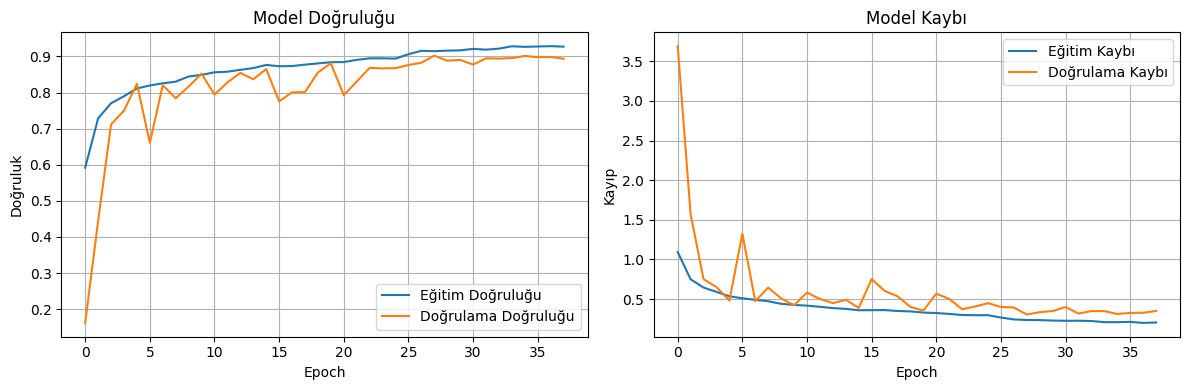

In [22]:
#modeli derleme
cnn_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

#Callback'leri tanımlayalım(erken durdurma ve öğrenme oranı ayarlama)
early_stopping= keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

#modeli eğitelim
start_time= time.time()

history = cnn_model.fit(datagen.flow(X_train, y_train_categorical, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

#eğitim ve doğrulama kaybı/doğruluğunu görselleştirelim
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Modelin Derlemesi ve Eğitimi  

### 1. Derleme (Compile)  
- **Optimizer**: `Adam` -> öğrenmeyi otomatik ayarlayan ve yaygın kullanılan bir optimizer.
- **Loss Function**: `categorical_crossentropy` -> çok sınıflı sınıflandırma için uygun kayıp fonksiyonu.
- **Metrikler**: `accuracy` -> modelin doğruluk oranı takip edildi.


### 2. Callback'ler  
- **EarlyStopping**:
   - `monitor='val_loss'` -> doğrulama kaybı izlenir.
   - `patience=10` -> üst üste 10 epoch boyuna gelişme olmazsa eğitim durur.
   - `restore_best_weights=True` -> en iyi ağırlıklar geri yüklenir.
- **ReduceLROnPlateau**:
   - `factor=0.2` -> öğrenme oranı 5 epoch boyuna gelişme olmazsa %20'ye düşürülür.
   - `min_lr=0.0001` -> öğrenme oranı bu değerin altına inmez.


### 3. Eğitim  
- Eğitim 50 epoch için başlatılmış, batch size = 64 olarak ayarlanmıştır.
- **Eğitim verisine** data augmentation uygulanmıştır.
- **Doğrulama seti**: Ayrılan test verisi kullanılmıştır.
- Eğitim süresi ölçülerek ekrana yazdırılmıştır.


### 4. Sonuçların Görselleştirilmesi  
- Eğitim ve doğrulama doğruluğu grafiği çizilmiştir.
- Eğitim ve doğrulama kaybı grafiği çizilmiştir.
- Bu grafikler , modelin **overfitting** veya **underfitting** eğilimlerini gözlemlemek için kullanılır.  

## 5.Model Değerlendirme

Test Kaybı:0.3055
Test Doğruluğu:0.9020
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

   buildings       0.94      0.87      0.90       438
      forest       0.93      0.99      0.96       454
     glacier       0.87      0.87      0.87       481
    mountain       0.87      0.86      0.86       503
         sea       0.92      0.92      0.92       455
      street       0.90      0.91      0.90       476

    accuracy                           0.90      2807
   macro avg       0.90      0.90      0.90      2807
weighted avg       0.90      0.90      0.90      2807



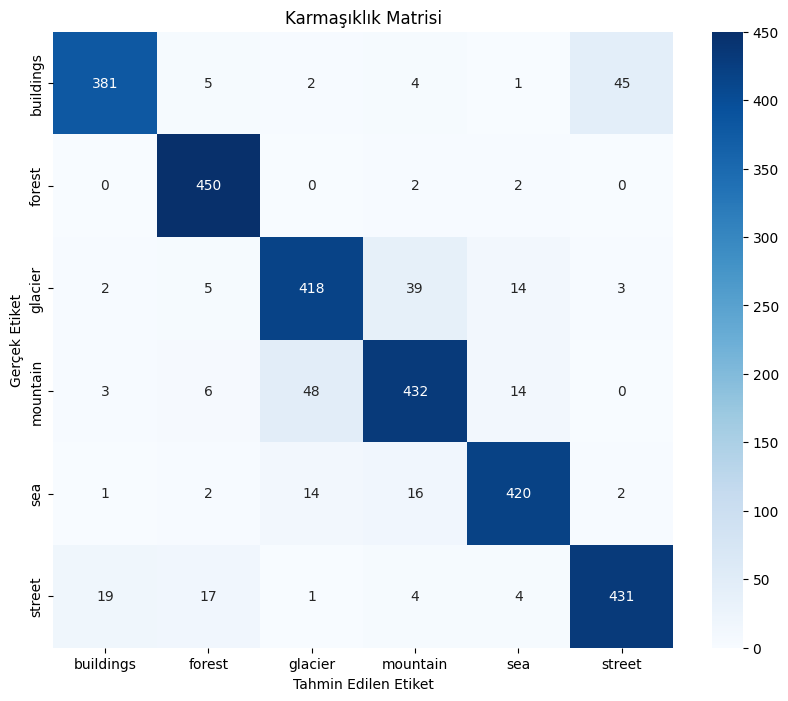

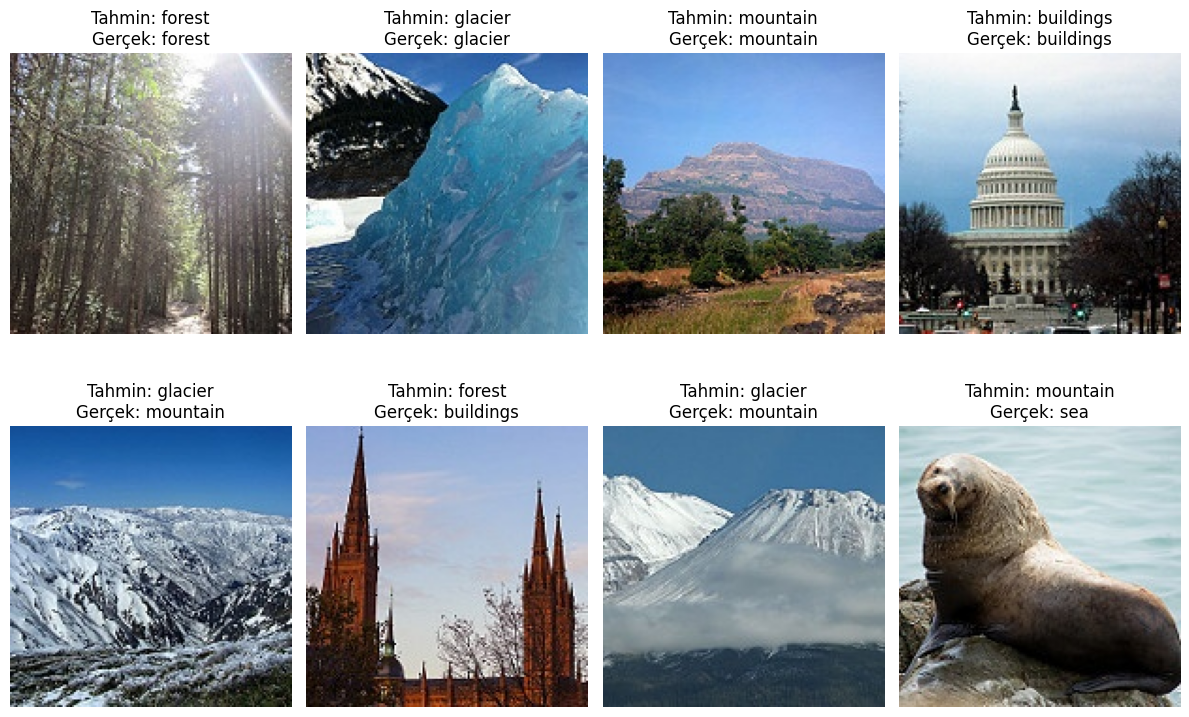

In [23]:
#test seti üzerinde model değerlendirme
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Test Kaybı:{test_loss:.4f}")
print(f"Test Doğruluğu:{test_accuracy:.4f}")

#tahminlerde bulunma
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

#sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

#karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

#bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices= np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12,8))

#doğru tahmin örnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2,4,i+1)
    plt.imshow(X_test[correct])
    plt.title(f"Tahmin: {class_names[y_pred_classes[correct]]}\nGerçek: {class_names[y_true[correct]]}")
    plt.axis('off')

#yanlış tahmin örnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2,4,i+5)
    plt.imshow(X_test[incorrect])
    plt.title(f"Tahmin: {class_names[y_pred_classes[incorrect]]}\nGerçek: {class_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Modelin Test Seti Üzerinde Değerlendirilmesi

### 1. Test Performansı
- Model, **ayrılan test seti** üzerinde değerlendirilmiştir.  
- **Test Kaybı** ve **Test Doğruluğu** ekrana yazdırılmıştır.  
  - Test doğruluğu → Modelin hiç görmediği veriler üzerindeki genel başarısını gösterir.  

### 2. Tahminler ve Karşılaştırma
- Model test setindeki veriler için tahminlerde bulunmuştur (`predict`).  
- Tahmin edilen etiketler (`y_pred_classes`) ve gerçek etiketler (`y_true`) karşılaştırılmıştır.  

### 3. Sınıflandırma Raporu
- **Precision (Kesinlik)**, **Recall (Duyarlılık)** ve **F1-score** metrikleri her sınıf için hesaplanmıştır.  
- Bu metrikler, modelin hangi sınıflarda güçlü veya zayıf olduğunu göstermektedir.  

### 4. Karmaşıklık Matrisi (Confusion Matrix)
- Modelin hangi sınıfları doğru, hangilerini yanlış tahmin ettiğini görselleştirmek için **heatmap** çizilmiştir.  
- Yatay eksen = Tahmin edilen sınıf, Dikey eksen = Gerçek sınıf.  
- Bu sayede hataların dağılımı daha net görülebilir.  

### 5. Doğru ve Yanlış Tahmin Örnekleri
- Test setinden bazı örnekler seçilerek görselleştirilmiştir.  
- İlk 4 görsel → doğru tahmin edilen örnekler.  
- Sonraki 4 görsel → yanlış tahmin edilen örnekler.  
- Her görselde **tahmin edilen sınıf** ve **gerçek sınıf** başlık olarak yazılmıştır.  

Bu adım, modelin sadece sayısal metrikler üzerinden değil, görsel inceleme yoluyla da değerlendirilmesine imkân sağlar.


## 6.Transfer Learning

In [27]:
#önceden eğitilmiş VGG16 modelini kullanalım
base_model = keras.applications.VGG16(weights='imagenet',
                                     include_top=False,
                                     input_shape=(150,150,3))
#temel modelin katmanlarını donduralım
for layer in base_model.layers:
    layer.trainable = False

#yeni bir model oluşturma
transfer_model =keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

#modeli derleyelim
transfer_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
transfer_model.summary()

#modeli eğitelim
history_transfer = transfer_model.fit(datagen.flow(X_train, y_train_categorical, batch_size=32),
                                     epochs=20,
                                     validation_data=(X_test, y_test_categorical),
                                     verbose=1)

#transfer learning modelini değerlendirelim
test_loss_transfer, test_accuracy_transfer= transfer_model.evaluate(X_test, y_test_categorical,verbose=0)
print(f"Transfer Learning Test Doğruluğu:{test_accuracy_transfer:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 171ms/step - accuracy: 0.5958 - loss: 1.0053 - val_accuracy: 0.8372 - val_loss: 0.4548
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.7913 - loss: 0.5513 - val_accuracy: 0.8429 - val_loss: 0.4251
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.8213 - loss: 0.4764 - val_accuracy: 0.8536 - val_loss: 0.4032
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.8324 - loss: 0.4513 - val_accuracy: 0.8568 - val_loss: 0.3824
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.8381 - loss: 0.4329 - val_accuracy: 0.8596 - val_loss: 0.3834
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.8341 - loss: 0.4367 - val_accuracy: 0.8646 - val_loss: 0.3653
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.8445 - loss: 0.4162 - val_accuracy: 0.8732 - val_loss: 0.3616
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.8438 - loss: 0

## Transfer Learning: VGG16 Kullanımı

### 1. Önceden Eğitilmiş Model (Base Model)
- **VGG16** modeli, ImageNet veri seti üzerinde önceden eğitilmiş ağırlıklarla yüklenmiştir.  
- `include_top=False` → VGG16’nın son (sınıflandırıcı) katmanı çıkarılmıştır.  
- Bu sayede sadece **özellik çıkarıcı (feature extractor)** kısmı kullanılmaktadır.  

### 2. Katmanların Dondurulması
- VGG16’nın tüm katmanları **eğitilemez (trainable=False)** yapılmıştır.  
- Böylece bu katmanların ağırlıkları değiştirilmeden, sadece yeni eklenen katmanlar eğitilecektir.  

### 3. Yeni Katmanlar (Transfer Model)
- **GlobalAveragePooling2D** → Uzamsal boyutları küçültüp öznitelik vektörüne dönüştürür.  
- **Dense (256 nöron, ReLU)** → Öğrenmeyi sağlar.  
- **Dropout (0.5)** → Aşırı öğrenmeyi önlemek için.  
- **Dense (Çıkış, Softmax)** → Çok sınıflı sınıflandırma için son katman.  

### 4. Derleme ve Eğitim
- **Optimizer**: Adam  
- **Loss Function**: Categorical Crossentropy  
- **Metrik**: Accuracy  
- Model 20 epoch boyunca, `batch_size=32` ile eğitilmiştir.  

### 5. Değerlendirme
- Test verisi üzerinde modelin performansı ölçülmüş ve **Transfer Learning doğruluk skoru** ekrana yazdırılmıştır.  
- Bu yaklaşım, sıfırdan eğitilen CNN modeline kıyasla genellikle daha yüksek doğruluk verir.  


## 7.Veri Görselleştirme ve Model Karşılaştırması

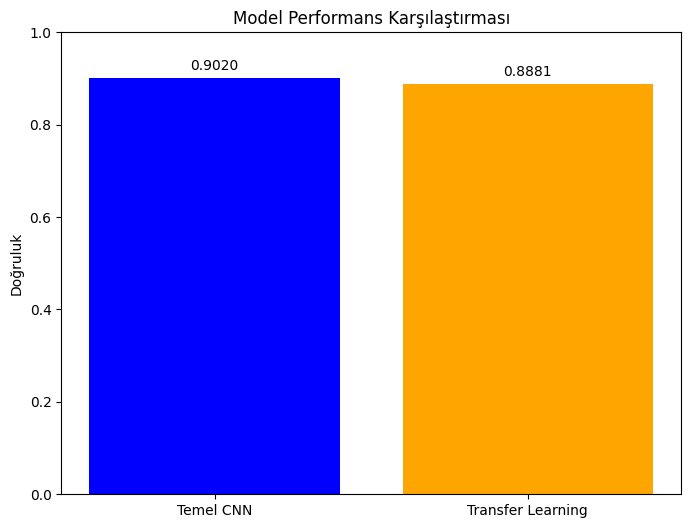

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


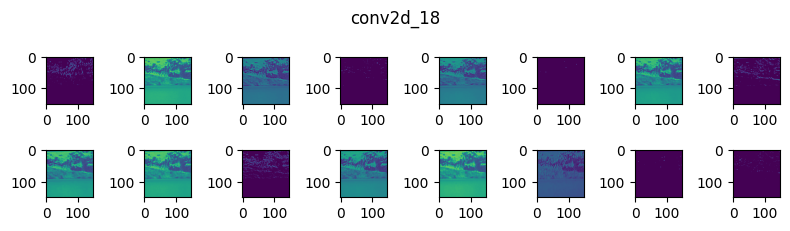

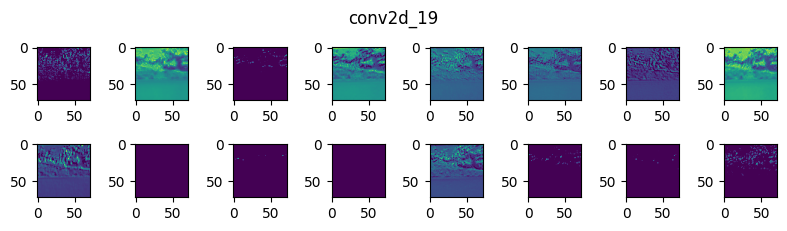

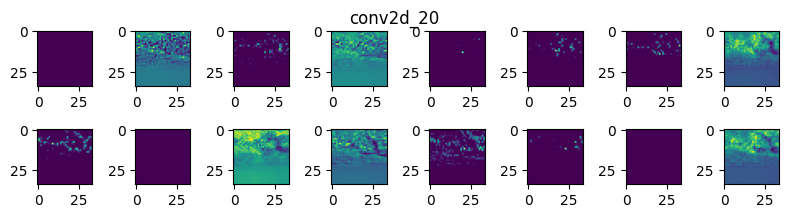

In [46]:
#model performanslarını karşılaştıralım
models=['Temel CNN', 'Transfer Learning']
accuracies= [test_accuracy, test_accuracy_transfer]

plt.figure(figsize=(8,6))
bars= plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0,1)

#çubukların üzerine doğruluk değerlerine yazalım
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01,
            f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()

#öznitelik haritalarını görselleştirme
#modelin girişini tanımlayalım
from tensorflow.keras import layers, models

inputs = keras.Input(shape=(150, 150, 3))   # Giriş tanımı
x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(6, activation='softmax')(x)

cnn_model = models.Model(inputs=inputs, outputs=outputs)


#ilk 8 evrişim katmanını 
conv_layers = [layer for layer in cnn_model.layers if isinstance(layer, layers.Conv2D)][:8]
layers_outputs=[layer.output for layer in conv_layers]
activation_model= keras.models.Model(inputs=cnn_model.input, outputs=layers_outputs)

#aktivasyonları hesaplayalım
img = X_test[10:11]
activations = activation_model.predict(img)

#ilk 16 filtreyi görselleştirelim

for layer_name, layer_activation in zip([layer.name for layer in conv_layers], activations):
    n_filters = layer_activation.shape[-1]
    n_cols = 8
    n_rows = n_filters //n_cols
    
    plt.figure(figsize=(n_cols, n_rows))
    plt.suptitle(layer_name)
    
    for i in range(min(n_filters, 16)):#ilk 16 filtre
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(layer_activation[0 , : , : ,i], cmap='viridis')

    plt.tight_layout()
    plt.show()
    
    
    

## Model Performans Karşılaştırması ve Öznitelik Haritalarının Görselleştirilmesi

### 1. Model Performans Karşılaştırması
- Temel CNN ve Transfer Learning modellerinin test doğrulukları karşılaştırılmıştır.  
- Bir çubuk grafik ile her iki modelin başarısı görselleştirilmiş ve doğruluk değerleri çubukların üzerine yazdırılmıştır.  
- Bu grafik, hangi modelin daha iyi performans gösterdiğini hızlıca anlamayı sağlar.

### 2. Öznitelik (Feature) Haritalarının Görselleştirilmesi
- CNN modelinin **ilk evrişim katmanları** incelenerek görsellerin hangi özellikleri öğrendiği gözlemlenmiştir.  
- Modelin girişine bir test resmi verilmiş ve **katman aktivasyonları (feature maps)** hesaplanmıştır.  
- Her evrişim katmanının **ilk 16 filtresi**, `viridis` renk haritası ile görselleştirilmiştir.  
- Bu sayede modelin **kenar, doku ve diğer görsel özellikleri nasıl algıladığı** anlaşılabilir.

### Önemli Noktalar
- Öznitelik haritaları, CNN’in “görsel bilgiyi nasıl işlediğini” anlamak için kullanılır.  
- Performans karşılaştırması ise, farklı yaklaşımların (sıfırdan CNN vs transfer learning) test seti üzerindeki doğruluğunu hızlıca gösterir.


## 8.Model İyileştirme Teknikleri


Adam optimizer ile eğitim...
Adam Test Doğruluğu: 0.8440

RMSprop optimizer ile eğitim...
RMSprop Test Doğruluğu: 0.8162

SGD optimizer ile eğitim...
SGD Test Doğruluğu: 0.7634


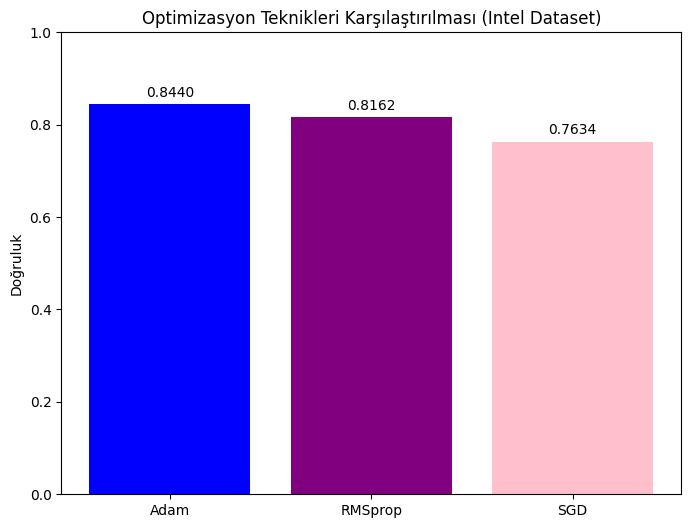

In [48]:
#farklı optimizatörler
optimizers = {
    'Adam':keras.optimizers.Adam(learning_rate=0.001),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'SGD':keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    
}

results= {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{opt_name} optimizer ile eğitim...")
    
    model = create_cnn_model()
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    history=model.fit(X_train, y_train_categorical,
                     epochs=10,
                     validation_data=(X_test, y_test_categorical),
                     verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
    results[opt_name] = test_acc
    print(f"{opt_name} Test Doğruluğu: {test_acc:.4f}")

#optimizasyon tekniklerini görselleştirme
plt.figure(figsize=(8,6))
bars = plt.bar(results.keys(),results.values(), color=['blue','purple','pink'])
plt.title('Optimizasyon Teknikleri Karşılaştırılması (Intel Dataset)')
plt.ylabel('Doğruluk')
plt.ylim(0,1)

for bar, accuracy in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2,bar.get_height() + 0.01,
            f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()

## Farklı Optimizatörlerin Karşılaştırılması

### 1. Kullanılan Optimizatörler
- **Adam**: Adaptif öğrenme oranı kullanan yaygın bir optimizer.  
- **RMSprop**: Özellikle sıralı veriler ve derin ağlarda iyi performans gösterir.  
- **SGD (Momentum ile)**: Klasik stochastic gradient descent, momentum ile daha hızlı yakınsama sağlar.

### 2. Deneyin Yapısı
- Her bir optimizatör ile **temel CNN modeli** sıfırdan oluşturulmuş ve 10 epoch boyunca eğitilmiştir.  
- Eğitim sırasında doğrulama verisi (`X_test, y_test_categorical`) kullanılmıştır.  
- Test doğruluğu her optimizatör için hesaplanmıştır ve `results` sözlüğünde saklanmıştır.

### 3. Sonuçların Görselleştirilmesi
- Test doğrulukları bir **çubuk grafik** ile görselleştirilmiştir.  
- Her çubuğun üzerinde doğruluk değeri yazılmıştır.  
- Bu grafik, hangi optimizatörün Intel Image Classification veri seti üzerinde daha iyi performans gösterdiğini hızlıca gösterir.

### Önemli Noktalar
- Optimizatör seçimi, modelin öğrenme hızını ve doğruluğunu doğrudan etkiler.  
- Bu deney, farklı optimizatörlerin performans farklarını görsel olarak karşılaştırmayı sağlar.


## 9.Sonuçlar ve Değerlendirme

In [51]:
print("="*50)
print("INTEL IMAGE CLASSIFICATION PROJE SONUÇLARI")
print("="*50)
print(f"Temel CNN Model Doğruluğu: {test_accuracy:.4f}")
print(f"Transfer Learning Model Doğruluğu: {test_accuracy_transfer:.4f}")
print(f"En İyi Optimizer: {max(results, key=results.get)} ({max(results.values()):.4f})")
print("="*50)

INTEL IMAGE CLASSIFICATION PROJE SONUÇLARI
Temel CNN Model Doğruluğu: 0.9020
Transfer Learning Model Doğruluğu: 0.8881
En İyi Optimizer: Adam (0.8440)


## Proje Sonuçları Özeti

- Bu bölümde, tüm deneylerin **ana sonuçları** ekrana yazdırılmıştır.  
- **Temel CNN Model Doğruluğu**: Sıfırdan eğitilen temel CNN modelinin test seti üzerindeki doğruluk oranı.  
- **Transfer Learning Model Doğruluğu**: Önceden eğitilmiş VGG16 tabanlı modelin test doğruluğu.  
- **En İyi Optimizatör**: Farklı optimizatörler ile yapılan denemelerde en yüksek doğruluk sağlayan optimizatör ve doğruluk değeri.  
